In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.model_selection import cross_val_score
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv("London.csv")
pd.options.display.float_format = '{:20,.2f}'.format


### Quick look at the dataset info

In [3]:
df.head()


,Unnamed: 0,Property Name,Price,House Type,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions,Location,City/County,Postal Code
0,0,Queens Road,1675000,House,2716,5,5,5,Wimbledon,London,SW19 8NY
1,1,Seward Street,650000,Flat / Apartment,814,2,2,2,Clerkenwell,London,EC1V 3PA
2,2,Hotham Road,735000,Flat / Apartment,761,2,2,2,Putney,London,SW15 1QL
3,3,Festing Road,1765000,House,1986,4,4,4,Putney,London,SW15 1LP
4,4,Spencer Walk,675000,Flat / Apartment,700,2,2,2,Putney,London,SW15 1PL


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3480 non-null   int64 
 1   Property Name      3480 non-null   object
 2   Price              3480 non-null   int64 
 3   House Type         3480 non-null   object
 4   Area in sq ft      3480 non-null   int64 
 5   No. of Bedrooms    3480 non-null   int64 
 6   No. of Bathrooms   3480 non-null   int64 
 7   No. of Receptions  3480 non-null   int64 
 8   Location           2518 non-null   object
 9   City/County        3480 non-null   object
 10  Postal Code        3480 non-null   object
dtypes: int64(6), object(5)
memory usage: 299.2+ KB


In [5]:
df.describe()

,Unnamed: 0,Price,Area in sq ft,No. of Bedrooms,No. of Bathrooms,No. of Receptions
count,"3,480.00","3,480.00","3,480.00","3,480.00","3,480.00","3,480.00"
mean,"1,739.50","1,864,172.54","1,712.97",3.10,3.10,3.10
std,"1,004.73","2,267,282.96","1,364.26",1.52,1.52,1.52
min,0.00,"180,000.00",274.00,0.00,0.00,0.00
25%,869.75,"750,000.00",834.00,2.00,2.00,2.00
50%,"1,739.50","1,220,000.00","1,310.00",3.00,3.00,3.00
75%,"2,609.25","2,150,000.00","2,157.25",4.00,4.00,4.00
max,"3,479.00","39,750,000.00","15,405.00",10.00,10.00,10.00


## Remove Bathrooms and Receptions
The number of bathrooms and receptions is a copy of the number of bedrooms, we are dropping them

In [6]:
df = df.drop('No. of Bathrooms',1)
df = df.drop('No. of Receptions',1)
df.head()

,Unnamed: 0,Property Name,Price,House Type,Area in sq ft,No. of Bedrooms,Location,City/County,Postal Code
0,0,Queens Road,1675000,House,2716,5,Wimbledon,London,SW19 8NY
1,1,Seward Street,650000,Flat / Apartment,814,2,Clerkenwell,London,EC1V 3PA
2,2,Hotham Road,735000,Flat / Apartment,761,2,Putney,London,SW15 1QL
3,3,Festing Road,1765000,House,1986,4,Putney,London,SW15 1LP
4,4,Spencer Walk,675000,Flat / Apartment,700,2,Putney,London,SW15 1PL


In [7]:
df['Location'].value_counts()

Putney                  96
Barnes                  71
Wandsworth              70
Wimbledon               68
Esher                   64
                        ..
 Orpington               1
Upshirebury Green        1
Ennismore Gardens        1
91 City Road             1
29 Sheffield Terrace     1
Name: Location, Length: 656, dtype: int64

In [8]:
df['City/County'].value_counts().head()

London        2972
Surrey         262
Middlesex       78
Essex           62
Twickenham      12
Name: City/County, dtype: int64

### Dropping Location City/County columns
The Location and City/County columns are not consistent (sometimes postcode is reported and things like that)
Plus the location information is going to be provided by the postcode
Plus removing Unnamed (just the index) and Property Name, which is useless for the prediction


In [9]:
df = df.drop('Location',1)
df = df.drop('Unnamed: 0',1)
df = df.drop('City/County',1)
df = df.drop('Property Name',1)

In [10]:
df.head()

,Price,House Type,Area in sq ft,No. of Bedrooms,Postal Code
0,1675000,House,2716,5,SW19 8NY
1,650000,Flat / Apartment,814,2,EC1V 3PA
2,735000,Flat / Apartment,761,2,SW15 1QL
3,1765000,House,1986,4,SW15 1LP
4,675000,Flat / Apartment,700,2,SW15 1PL


### Modifying postcode 
The last two chars of the postcode represent the unit and it is too granular. We are going to loose them to represent the subdistrict only

In [11]:
df['Postal Code Norm'] = df['Postal Code'].transform(lambda x: x[:-2].replace(" ",''))

### Categorising Postal Code and House Type and creating a category only column for both

In [12]:
df["Postal Code Norm"] = pd.Categorical(df['Postal Code Norm'])
df['House Type'] = pd.Categorical(df['House Type'])
df['Postcode cat'] = df["Postal Code Norm"].cat.codes
df['Type cat'] = df['House Type'].cat.codes

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Area in sq ft'}>],
       [<AxesSubplot:title={'center':'No. of Bedrooms'}>,
        <AxesSubplot:title={'center':'Postcode cat'}>],
       [<AxesSubplot:title={'center':'Type cat'}>, <AxesSubplot:>]],
      dtype=object)

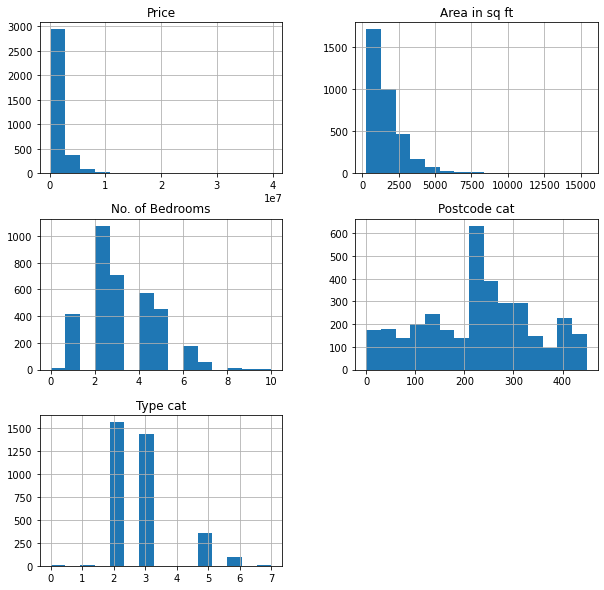

In [13]:
df.hist(bins=15,figsize=(10,10))

<AxesSubplot:>

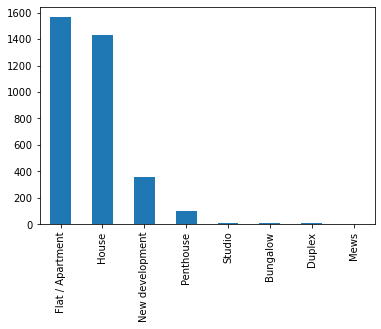

In [14]:
df['House Type'].value_counts().plot.bar()

### Correlation matrix for the price

In [15]:
df.corr()['Price']

Price                             1.00
Area in sq ft                     0.67
No. of Bedrooms                   0.44
Postcode cat                      0.18
Type cat                          0.18
Name: Price, dtype: float64

### 75% of the postcode have max 10 house prices. This means that the postcode can't be used effectively for the prediction?

In [16]:
df.groupby(by="Postal Code Norm").count().describe()

,Price,House Type,Area in sq ft,No. of Bedrooms,Postal Code,Postcode cat,Type cat
count,450.00,450.00,450.00,450.00,450.00,450.00,450.00
mean,7.73,7.73,7.73,7.73,7.73,7.73,7.73
std,9.75,9.75,9.75,9.75,9.75,9.75,9.75
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,2.00,2.00,2.00,2.00,2.00,2.00,2.00
50%,4.00,4.00,4.00,4.00,4.00,4.00,4.00
75%,10.00,10.00,10.00,10.00,10.00,10.00,10.00
max,75.00,75.00,75.00,75.00,75.00,75.00,75.00


In [17]:
df

,Price,House Type,Area in sq ft,No. of Bedrooms,Postal Code,Postal Code Norm,Postcode cat,Type cat
0,1675000,House,2716,5,SW19 8NY,SW198,260,3
1,650000,Flat / Apartment,814,2,EC1V 3PA,EC1V3,58,2
2,735000,Flat / Apartment,761,2,SW15 1QL,SW151,234,2
3,1765000,House,1986,4,SW15 1LP,SW151,234,3
4,675000,Flat / Apartment,700,2,SW15 1PL,SW151,234,2
...,...,...,...,...,...,...,...,...
3475,3350000,New development,1410,3,SW6 1UE,SW61,301,5
3476,5275000,Flat / Apartment,1749,3,SW1A 1JT,SW1A1,261,2
3477,5995000,House,4435,6,NW11 6TG,NW116,154,3
3478,6300000,New development,1506,3,W1S 3AR,W1S3,381,5


### Select only the columns for the prediction

In [18]:
X = df[['Area in sq ft',"No. of Bedrooms","Postcode cat","Type cat"]]

In [19]:
Y = df[['Price']]

In [20]:
X,Y

(      Area in sq ft  No. of Bedrooms  Postcode cat  Type cat
 0              2716                5           260         3
 1               814                2            58         2
 2               761                2           234         2
 3              1986                4           234         3
 4               700                2           234         2
 ...             ...              ...           ...       ...
 3475           1410                3           301         5
 3476           1749                3           261         2
 3477           4435                6           154         3
 3478           1506                3           381         5
 3479           5395                6           140         3
 
 [3480 rows x 4 columns],
         Price
 0     1675000
 1      650000
 2      735000
 3     1765000
 4      675000
 ...       ...
 3475  3350000
 3476  5275000
 3477  5995000
 3478  6300000
 3479  8650000
 
 [3480 rows x 1 columns])

In [21]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

In [22]:
algorithms = {'Linear Regression':LinearRegression(),
             'Random Forest Regressor':RandomForestRegressor(),
             'Lasso':Lasso(),
             'SVR':SVR(),
             'Ridge':Ridge()}
scoring = {}
for model_name,model in algorithms.items():
    # y.fit(X_train,Y_train)
    scores = cross_val_score(model,X,Y.values.ravel(),cv=10,scoring='neg_mean_squared_error')
    scoring[model_name] = {'MEAN':-scores.mean(),"STD":scores.std()}

scoring

{'Linear Regression': {'MEAN': 2761942880149.65, 'STD': 3000081947474.324},
 'Random Forest Regressor': {'MEAN': 1735182844608.2007,
  'STD': 1947867937824.3225},
 'Lasso': {'MEAN': 2761943064790.708, 'STD': 3000083539317.799},
 'SVR': {'MEAN': 5562312797334.889, 'STD': 6450868321214.545},
 'Ridge': {'MEAN': 2761937857865.355, 'STD': 3000181671794.711}}

### Random Forest Regressor is the candidate
### Trying it on the training set

In [23]:
model = RandomForestRegressor()
model.fit(X,Y)

print("SQUARE MEAN ERROR OF TRAINING SET: "+str(mean_squared_error(model.predict(X),Y)))
print("MEAN SQUARE MEAN ERROR OF KFOLDS: "+str(scoring['Random Forest Regressor']['MEAN']))

<ipython-input-23-44754e635564>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X,Y)


SQUARE MEAN ERROR OF TRAINING SET: 207519220981.0325
MEAN SQUARE MEAN ERROR OF KFOLDS: 1735182844608.2007


### The model doesn't overfit the training set

Grid Search CV for hyperparameter tuning

In [27]:
model = RandomForestRegressor()
param_grid = [{'n_estimators':[3,10,30],'max_features':[1,2,3,4]},
              {'bootstrap':[False],'n_estimators':[3,10],'max_features':[1,2,3,4]}
              ]
grid_search = GridSearchCV(model,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(X,Y.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [1, 2, 3, 4],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [1, 2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [38]:
grid_search.best_params_
best_model = grid_search.best_estimator_
list(zip(grid_search.cv_results_['params'],-grid_search.cv_results_['mean_test_score']))

[({'max_features': 1, 'n_estimators': 3}, 2471120880899.688),
 ({'max_features': 1, 'n_estimators': 10}, 2142390745210.763),
 ({'max_features': 1, 'n_estimators': 30}, 2051031477507.0688),
 ({'max_features': 2, 'n_estimators': 3}, 2224874630843.344),
 ({'max_features': 2, 'n_estimators': 10}, 2010890222358.7585),
 ({'max_features': 2, 'n_estimators': 30}, 1922014959927.8735),
 ({'max_features': 3, 'n_estimators': 3}, 2191390767641.9277),
 ({'max_features': 3, 'n_estimators': 10}, 1981640390566.8022),
 ({'max_features': 3, 'n_estimators': 30}, 1874218764887.532),
 ({'max_features': 4, 'n_estimators': 3}, 2170164413627.118),
 ({'max_features': 4, 'n_estimators': 10}, 1932345871418.321),
 ({'max_features': 4, 'n_estimators': 30}, 1888811532755.786),
 ({'bootstrap': False, 'max_features': 1, 'n_estimators': 3},
  2300767317466.837),
 ({'bootstrap': False, 'max_features': 1, 'n_estimators': 10},
  2020570760567.6086),
 ({'bootstrap': False, 'max_features': 2, 'n_estimators': 3},
  217498176

### Best params scores

In [39]:
mean_squared_error(best_model.predict(X),Y)

221722887389.06107

Analyze the feature importance

In [41]:
best_model.feature_importances_

array([0.59841757, 0.08321532, 0.2495762 , 0.0687909 ])

In [44]:
X.labels


AttributeError: 'DataFrame' object has no attribute 'labels'

In [48]:
list(zip(X.columns.values,best_model.feature_importances_))

[('Area in sq ft', 0.5984175707068545),
 ('No. of Bedrooms', 0.08321532160024384),
 ('Postcode cat', 0.24957620465552194),
 ('Type cat', 0.06879090303737984)]

In [58]:
list(df['House Type'].cat.categories.values)

['Bungalow',
 'Duplex',
 'Flat / Apartment',
 'House',
 'Mews',
 'New development',
 'Penthouse',
 'Studio']

In [61]:
def predict_house_price(sqft,num_bed,postcode,type):
    type_cat = list(df['House Type'].cat.categories.values).index(type)
    postcode_cat = list(df['Postal Code Norm'].cat.categories.values).index(postcode)
    return best_model.predict([[sqft,num_bed,postcode_cat,type_cat]])

In [71]:
predict_house_price(950,3,'SW151','Flat / Apartment')


array([788161.66666667])